In [ ]:
!pip install einops

In [ ]:
import os
import sys
import torch
import torchvision
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from tqdm import tqdm

from random_eigenframe_model import RandomEigenframeModel
from scipy.spatial.distance import cdist
from einops import repeat, rearrange

In [ ]:
torch.cuda.is_available()

True

In [ ]:
path = os.path.join(os.getcwd(), 'results')
if not os.path.exists(path):
  os.makedirs(path)

# Load MNIST images dataset

In [ ]:
batch_size_train = 16
batch_size_test = 16

In [ ]:
img_size = 12

train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Resize((img_size, img_size)),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Resize((img_size, img_size)),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

In [ ]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
example_data.shape

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


torch.Size([16, 1, 12, 12])

In [ ]:
rearrange(example_data, 'b c n1 n2 -> b c (n1 n2)').shape

torch.Size([16, 1, 144])

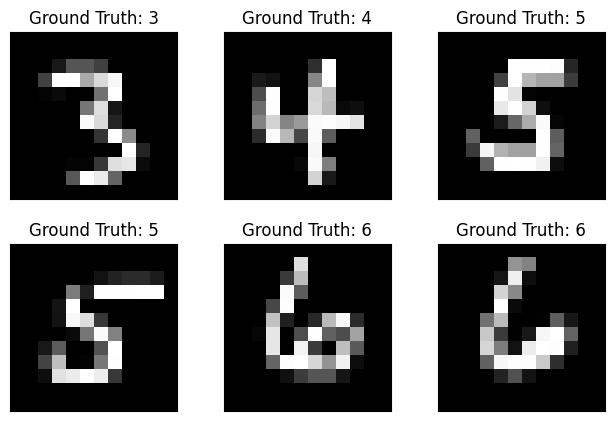

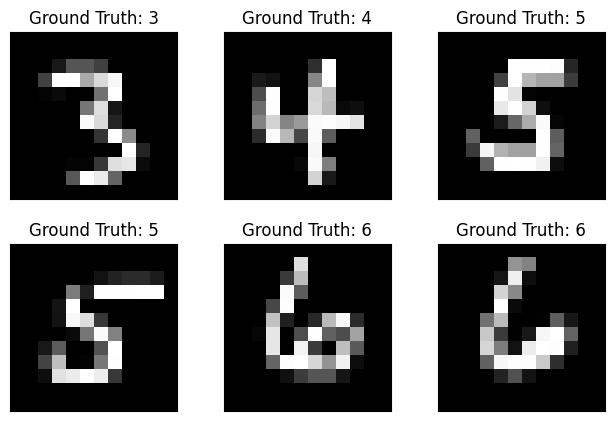

In [ ]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(rearrange(example_data[i], 'c n1 n2 -> c (n1 n2)').reshape(img_size, img_size),
             cmap='gray',
             interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

# MNIST images to graphs

In [ ]:
def draw_graph_mpl(g, pos=None, ax=None, layout_func=nx.drawing.layout.kamada_kawai_layout, draw_labels=True):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(20, 20))
    else:
        fig = None
    if pos is None:
        pos = layout_func(g)
    node_color = []
    node_labels = {}
    shift_pos = {}
    for k in g:
        node_color.append(g.nodes[k].get('color', 'green'))
        node_labels[k] = g.nodes[k].get('label', k)
        shift_pos[k] = [pos[k][0], pos[k][1]]

    edge_color = []
    edge_width = []
    for e in g.edges():
        edge_color.append(g.edges[e].get('color', 'black'))
        edge_width.append(g.edges[e].get('width', 0.5))
    nx.draw_networkx_edges(g, pos, font_weight='bold', edge_color=edge_color, width=edge_width, alpha=0.5, ax=ax)
    nx.draw_networkx_nodes(g, pos, node_color=node_color, node_shape='p', node_size=300, alpha=0.75, ax=ax)
    if draw_labels:
        nx.draw_networkx_labels(g, shift_pos, labels=node_labels, arrows=True, ax=ax)
    ax.autoscale()
    return fig, ax, pos

In [ ]:
def img_laplacian(image_size=28):
  col, row = np.meshgrid(np.arange(image_size), np.arange(image_size)) # (28 x 28) Explanation: https://www.geeksforgeeks.org/numpy-meshgrid-function/
  coord = np.stack((col, row), axis = 2).reshape(-1, 2) / image_size # (784 x 2) --> normalize
  dist = cdist(coord, coord) # compute distance between every pair of pixels
  sigma = 0.05 * np.pi # width of the Gaussian (can be a hyperparameter while training a model)
  A = np.exp(-dist / sigma ** 2) # adjacency matrix of spatial similarity
  A[A < 0.01] = 0 # suppress values less than 0.01
  A = torch.from_numpy(A).float()

  # Normalization as per (Kipf & Welling, ICLR 2017)
  D = A.sum(1)  # nodes degree (N,)
  D_hat = (D + 1e-5) ** (-0.5)
  A_hat = D_hat.view(-1, 1) * A * D_hat.view(1, -1)  # N,N

  # Some additional trick I found to be useful
  A_hat[A_hat > 0.0001] = A_hat[A_hat > 0.0001] - 0.2

  L = torch.diag(A_hat.sum(dim=1)) - A_hat

  return L

# Model

In [ ]:
n_epochs = 16
learning_rate = 0.01
wd = 1e-4
log_interval = 50
reg_factor = 1

In [ ]:
device = 'cpu'#'cuda' if torch.cuda.is_available() else 'cpu'

network = RandomEigenframeModel(in_channels=1,
                                hidden_channels=[16, 32, 64],
                                n_classes=10,
                                k_bands=13,
                                m_samples=12,
                                l_frames=24)
network = network.to(device)

optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate, weight_decay=wd)

In [ ]:
def visualize(axs, model, img, layer, max_channels_to_print):
    """
    Visualize the intermediate activations of a given layer for a given image
    :param axs: vector of axes to plot on
    :param model: RandomEigenframeModel
    :param img: image to visualize
    :param layer: number of layer to visualize
    :param max_channels_to_print: number of channels to visualize
    :return: None
    """
    img = img.to(device)

    L = img_laplacian(img_size).unsqueeze(0)
    res = model(img.reshape(1, img_size ** 2, 1), L, return_intermediate=True, return_idx=True)
    intermediate = res['intermediate']
    idx = res['idx'].item()

    hidden_channels = model.hidden_channels[1:]

    num_channels_to_print = min(hidden_channels[layer], max_channels_to_print)

    conved = intermediate[layer]
    conved = conved.detach().to('cpu').squeeze(0)
    for j in range(num_channels_to_print):
      axs[j].imshow(conved[idx, :, j].reshape(img_size, img_size),
                  cmap='gray',
                  interpolation='none',
                  aspect='auto')

    for j in range(num_channels_to_print):
      axs[j].axis('off')
      axs[j].set_xticks([])
      axs[j].set_yticks([])
  # plt.savefig('./results/intermediate')
  # plt.show()

In [ ]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [ ]:
import time

def train(epoch):
  network.train()
  L = img_laplacian(image_size=img_size).to(device)
  for batch_idx, (data, target) in tqdm(enumerate(train_loader)):
    x, target = data.to(device), target.to(device)

    x = rearrange(x, 'b c n1 n2 -> b (n1 n2) c')
    bs = x.shape[0]
    batch_L = repeat(L, 'n1 n2 -> b n1 n2', b=bs)

    optimizer.zero_grad()
    output = network(x, batch_L)
    loss = F.nll_loss(output, target) # + reg_factor * network.regularization_term()
    loss.backward()
    optimizer.step()


    # if batch_idx % log_interval == 0:
    #   print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
    #     epoch, batch_idx * len(data), len(train_loader.dataset),
    #     100. * batch_idx / len(train_loader), loss.item()))
    #   train_losses.append(loss.item())
    #   train_counter.append(
    #     (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
    #   torch.save(network.state_dict(), './results/model.pth')
    #   torch.save(optimizer.state_dict(), './results/optimizer.pth')

In [ ]:
import time
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

def test():
  network.eval()
  L = img_laplacian(image_size=img_size).to(device)
  test_loss = 0

  targets = torch.empty(0).to(device)
  preds = torch.empty(0).to(device)

  correct = 0
  with torch.no_grad():
    for data, target in tqdm(test_loader):
      x, target = data.to(device), target.to(device)
      x = rearrange(x, 'b c n1 n2 -> b (n1 n2) c')
      bs = x.shape[0]
      batch_L = repeat(L, 'n1 n2 -> b n1 n2', b=bs)
      output = network(x, batch_L)
      test_loss += F.nll_loss(output, target, size_average=False).item() # + reg_factor * network.regularization_term()
      pred = output.max(dim=1).indices
      correct += pred.eq(target.data.view_as(pred)).sum()

      targets = torch.cat([targets, target])
      preds = torch.cat([preds, pred])
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

  ConfusionMatrixDisplay.from_predictions(targets.to('cpu').numpy(), preds.to('cpu').numpy())
  plt.show()


In [ ]:
# test()
# for epoch in range(1, n_epochs + 1):
#   train(epoch)
#   test()

## Load model

In [ ]:
device = 'cpu'#'cuda' if torch.cuda.is_available() else 'cpu'

def load_model(path = './results/model.pth'):
  network = RandomEigenframeModel(in_channels=1,
                                  hidden_channels=[16, 32, 64],
                                  n_classes=10,
                                  k_bands=13,
                                  m_samples=12,
                                  l_frames=24)
  network.load_state_dict(torch.load(path))
  network = network.to(device)
  network.eval()

  return network

load_model()

RandomEigenframeModel(
  (bp): BandPass()
  (localizing_mask): LocalizingMask()
  (conv_layers): ParameterList(
      (0): Object of type: RandomEigenframeFilter
      (1): Object of type: RandomEigenframeFilter
      (2): Object of type: RandomEigenframeFilter
    (0): RandomEigenframeFilter()
    (1): RandomEigenframeFilter()
    (2): RandomEigenframeFilter()
  )
  (classifier): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): Reduce('b f n c -> b f c', 'mean')
    (2): Linear(in_features=64, out_features=10, bias=True)
    (3): LogSoftmax(dim=2)
  )
)

# Vis

In [ ]:
delta = torch.zeros((1, img_size, img_size))
delta[0][img_size // 2][img_size // 2] = 1
delta = torchvision.transforms.Normalize((0.1307,), (0.3081,))(delta)

_, axs = plt.subplots(1, 3, figsize=(3 * 10, 5))

model = load_model()
visualize(axs[1:], model, delta, 0, 1)

axs[0].imshow(delta.reshape(img_size, img_size), cmap='gray',
                  interpolation='none',
                  aspect='auto')
axs[0].axis('off')

plt.savefig('')
plt.show()

In [ ]:
import matplotlib.pyplot as plt

def coefficients_plot(axs, model, layer, in_channel, max_channels_to_print):
  """
  Plot the coefficients of a given layer for a given input channel and 1..max_channels_to_print output channels
  :param axs: vector of axes to plot on
  :param model: RandomEigenframeModel
  :param layer: number of layer to visualize
  :param in_channel:  number of input channel to visualize
  :param max_channels_to_print: number of output channels to visualize
  :return: None
  """
  num_channels_to_print = min(max_channels_to_print, model.conv_layers[layer].coefficients.shape[2])

  for j in range(num_channels_to_print):
    coefficients = model.conv_layers[layer].coefficients.detach().to('cpu')[:, :, j, in_channel, :].flatten().tolist()

    axs[j].plot(range(len(coefficients)), coefficients)

  for j in range(num_channels_to_print):
    axs[j].axis('off')

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = RandomEigenframeModel(in_channels=1,
                                hidden_channels=[16, 32, 64],
                                n_classes=10,
                                k_bands=51,
                                m_samples=20,
                                l_frames=24)
model.to(device)

print(model.regularization_term())

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

layer_to_print = 1

num_epochs = 2000
_, axs = plt.subplots(10, 3, figsize=(3 * 10, 5 * 10))
cnt = 0
for i in range(num_epochs + 1):
  optimizer.zero_grad()

  loss = model.regularization_term()
  loss.backward()

  optimizer.step()

  if i % (num_epochs // 3) == 0 or i == num_epochs:
    with torch.no_grad():
      visualize(axs[cnt, :], model, example_data[1].to(device), layer_to_print, 3)
      coefficients_plot(axs[cnt+1, :], model, 0, 0, 3)
      cnt += 2
plt.savefig('Train_on_regularization.png')
plt.show()

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = RandomEigenframeModel(in_channels=1,
                                hidden_channels=[2],
                                n_classes=10,
                                k_bands=51,
                                m_samples=20,
                                l_frames=24)

model.conv_layers[0].coefficients = torch.nn.Parameter(torch.cat([
    torch.sin(torch.linspace(0, 2, model.k_bands * model.m_samples).reshape(1, 1, 1, 1, -1) * 10),
    torch.ones(1, 1, 1, 1, model.k_bands * model.m_samples)
], dim=2))

model.to(device)

visualize(model, example_data[0].to(device), 0, 2)